# Đặng Trung Cương

# INT3401E 20

## Import các thư viện cần thiết

In [61]:
import cv2
import os
import numpy as np
import random


import matplotlib.pyplot as plt
%matplotlib inline


In [62]:
TOTAL_LEVEL = 3 # Assume that the game has 3 levels

## Load dữ liệu

In [63]:
sample_image_path = 'sample_images' # Original images path
level_image_path = 'level_images' # Edited images path
result_image_path = 'result_images'
files = os.listdir(sample_image_path)


In [64]:
# Chọn 1 bức ảnh bất kì từ trong tập ảnh gốc
chosen_index = random.randrange(len(files))

In [65]:
def get_image_color_format(image):
    """
    :param image: ảnh đầu vào
    :return: định dạng màu ảnh
    """
    if image.shape[2] == 3:
        return 'RGB'
    elif image.shape[2] == 4:
        return 'RGBA'
    else:
        return 'BGR'

def to_bgr(image):
    if get_image_color_format(image) == 'RGB':
        return cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    else: return image

RGB


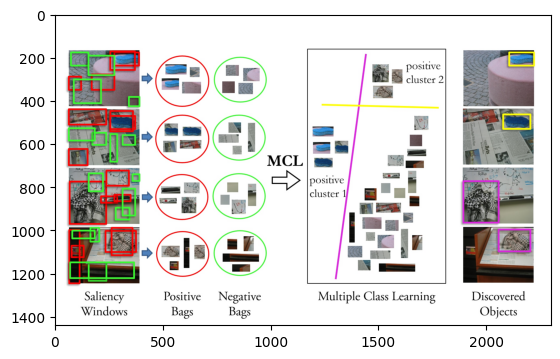

In [78]:
# Load ảnh
img = cv2.imread(sample_image_path+'/'+files[chosen_index])

# Chuyển ảnh từ các định dạng khác về BGR
# TODO: Other image format conversion.
cl_format = get_image_color_format(img)
print(cl_format)
true_img = None
gray_img = None

if cl_format == 'RGB':
    true_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    gray_img = cv2.cvtColor(true_img, cv2.COLOR_BGR2GRAY)
else:
    true_img = img
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(true_img)


## Phát hiện cạnh bằng Canny

Tiền xử lý:
- Bộ lọc Gaussian cửa sổ (1x1) - giữ lại thông tin (trong trường hợp ảnh ít nhiễu)
- Tính cận trên/dưới cho Canny.



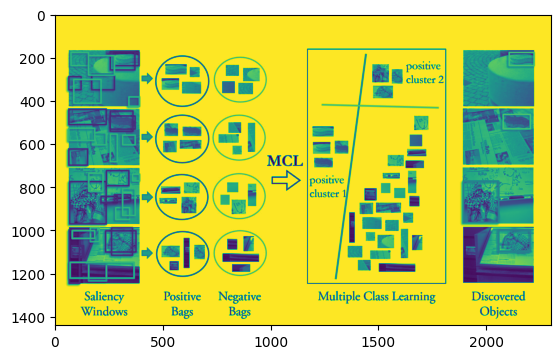

In [67]:
blurred = cv2.GaussianBlur(gray_img, (1,1), 0)
plt.imshow(blurred)

In [68]:
def get_threshold(image, sigma=0.33):
    """

    :param image: ảnh đầu vào
    :param sigma: hyperparameter
    :return: cận trên/dưới
    """
    v = np.median(image)
    lower_thresh = int(max(0, (1.0 - sigma) * v))
    upper_thresh = int(min(255, (1.0 + sigma) * v))

    # higher threshold for more edges
    return lower_thresh/1.5, upper_thresh*2

def auto_canny(image, sigma=0.33):
    """

    :param image: ảnh đầu vào
    :param sigma: hyperparameter
    :return: ảnh cạnh
    """
    v = np.median(image)

    l, u = get_threshold(image)
    canny_edges = cv2.Canny(image, l, u)
    return canny_edges



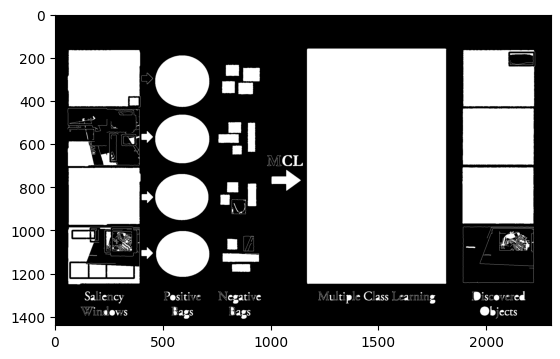

In [69]:
edges = auto_canny(blurred)

# cv2.RETR_TREE + cv2.CHAIN_APPROX_NONE: lấy toàn bộ contours
contours, hrc = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# Khởi tạo hình rỗng để làm mask
contour_img = np.zeros((gray_img.shape[0], gray_img.shape[1], 3), dtype= 'uint8')
color = [255,255,255]

for c in contours:
    # fill
    cv2.fillPoly(contour_img, [c], color)

plt.imshow(contour_img)

### Chọn lấy những contours đủ lớn về mặt diện tích ( >= 1% diện tích ảnh)

In [70]:
def get_eligible_contours(image, ctrs):
   eligible_ctrs = []

   for c in contours:
        cnt_area = cv2.contourArea(c)
        if cnt_area >= 0.01 * img.shape[0] * img.shape[1]:
            eligible_ctrs.append(c)
   return eligible_ctrs

## Create data

- Tự động tạo dữ liệu cho 3 cấp độ bằng cách tô màu các contours
- Số lượng contour được tô màu = int(len(final_contours/TOTAL_LEVEL*current_level)
- Dữ liệu ảnh cho các level được lưu vào thư mục /level_images

In [71]:
file_name = ''
name = files[chosen_index]
file_name_split = name.split('.')
for idx in range (len(file_name_split)-1):
    file_name += file_name_split[idx]
final_contours = get_eligible_contours(edges, contours)
# Tên file gốc
file_name_og = file_name + '.' + file_name_split[len(file_name_split)-1]


for i in range(1, TOTAL_LEVEL+1):
    num_contour_this_level = int(len(final_contours)/TOTAL_LEVEL*i) # Số lượng contours sẽ tô màu cho level này
    image_this_level = true_img.copy()
    im = to_bgr(image_this_level)
    for j in range(0, num_contour_this_level):
        r,g,b = random.randint(0,255), random.randint(0, 255), random.randint(1, 254) # avoid completely black/white painting
        cv2.fillPoly(im, pts=[final_contours[j]], color=[r,g,b])

    cv2.imwrite(level_image_path+'/'+file_name+'_lvl_'+str(i)+'.'+file_name_split[len(file_name_split)-1], im)


## Task 2: Solve the game

- Tính độ sai khác giữa 2 bức ảnh bằng hàm absdiff() của opencv.
- Tính


In [79]:
for i in range(1, TOTAL_LEVEL+1):

    # Load dữ liệu
    sample_image_file_name = file_name_og
    level_image_file_name = file_name + '_lvl_' + str(i)+'.'+ file_name_split[len(file_name_split)-1]
    result_image_file_name = 'result_'+level_image_file_name

    sample_img = to_bgr(cv2.imread(sample_image_path+'/'+sample_image_file_name))
    level_img = to_bgr(cv2.imread(level_image_path+'/'+level_image_file_name))
    # plt.imshow(level_img)
    sample_gray = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)
    level_gray = cv2.cvtColor(level_img, cv2.COLOR_BGR2GRAY)

    diff = 255 - cv2.absdiff(sample_gray, level_gray)
    diff = cv2.GaussianBlur(diff, (5,5), 0)

    # plt.imshow(diff)
    ret, diff = cv2.threshold(diff, 230, 255, cv2.THRESH_TOZERO)
    # diff = cv2.medianBlur(diff, 9)

    edged = auto_canny(diff)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    final_contours = get_eligible_contours(edged, contours)
    # contours_poly = [None] * len(contours)
    # print(len(final_contours))
    # for j, c in enumerate(final_contours):
    #  contours_poly[j] = cv2.approxPolyDP(c, 3, True)
    col = (0, 0, 0)

    for idx in range(len(final_contours)):
        cv2.drawContours(sample_img, final_contours, idx, col, 3, cv2.LINE_AA )

    cv2.imwrite(result_image_path+'/'+result_image_file_name, to_bgr(sample_img))
